In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

In [42]:
# Reading the MNIST dataset
def read_MNIST(path):
    data = pd.read_csv(path, skiprows=1)
    X = data.iloc[:, 1:].values.astype('float32') / 255.0
    Y = data.iloc[:, 0].values
    Y = tf.keras.utils.to_categorical(Y, 10)
    return X, Y

In [43]:
# Splitting data to test and train
def train_test_split(X, Y, split):
    limit = int(np.floor(split * len(X)))
    x_train, y_train = X[:limit], Y[:limit]
    x_test, y_test = X[limit:], Y[limit:]
    return x_train, y_train, x_test, y_test

# Creating TensorFlow datasets
def create_dataset(X, Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [44]:
# Defining the model
def create_model(input_shape, hidden_layers, output_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    return model

In [45]:
# Training function
def train_step(model, x, y, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [46]:
# Create a tf.function version of train_step
train_step_tf = tf.function(train_step)

In [47]:
# Compute accuracy of the network
@tf.function
def compute_accuracy(model, X, Y):
    predictions = model(X, training=False)
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [48]:
def train(model, train_dataset, test_dataset, epochs, optimizer):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(epochs):
        t0 = time.time()
        total_loss = 0
        num_batches = 0

        for x_batch, y_batch in train_dataset:
            loss = train_step_tf(model, x_batch, y_batch, loss_fn, optimizer)
            total_loss += loss
            num_batches += 1

        avg_loss = total_loss / num_batches
        train_accuracy = tf.reduce_mean([compute_accuracy(model, x, y) for x, y in train_dataset])
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
              f"Accuracy: {train_accuracy:.4f}, Time: {time.time()-t0:.2f}s")
        
    # Test accuracy
    test_accuracy = tf.reduce_mean([compute_accuracy(model, x, y) for x, y in test_dataset])
    print(f"Test Data Accuracy: {test_accuracy:.4f}")

In [49]:
def run(hidden_layers, learning_rate, epochs, split, batch_size):
    print(f"Epochs: {epochs}, LR: {learning_rate}, Hidden Layers: {hidden_layers}, "
          f"Split: {split}, Batch Size: {batch_size}")
    
    # Check for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"GPU is available: {physical_devices[0]}")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    else:
        print("No GPU available, using CPU")

    X, Y = read_MNIST("D:/Github/MNIST_CSV/mnist_train.csv")
    x_train, y_train, x_test, y_test = train_test_split(X, Y, split)

    train_dataset = create_dataset(x_train, y_train, batch_size)
    test_dataset = create_dataset(x_test, y_test, batch_size)

    input_shape = X.shape[1]
    output_shape = Y.shape[1]
    model = create_model((input_shape,), hidden_layers, output_shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    train(model, train_dataset, test_dataset, epochs, optimizer)

    # Save the trained model
    model.save('mnist_model.h5')
    print("Model saved as 'mnist_model.h5'")

    # Save the test dataset
    np.savez('test_dataset.npz', x_test=x_test, y_test=y_test)
    print("Test dataset saved as 'test_dataset.npz'")

    return model, test_dataset

In [50]:

# Run the training and save the model and test dataset
model, test_dataset = run(hidden_layers=[50], learning_rate=0.01, epochs=10, split=0.90, batch_size=32)

Epochs: 10, LR: 0.01, Hidden Layers: [50], Split: 0.9, Batch Size: 32
GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/10, Loss: 0.2534, Accuracy: 0.9496, Time: 5.88s
Epoch 2/10, Loss: 0.1654, Accuracy: 0.9560, Time: 4.88s
Epoch 3/10, Loss: 0.1485, Accuracy: 0.9645, Time: 4.96s
Epoch 4/10, Loss: 0.1336, Accuracy: 0.9642, Time: 5.28s
Epoch 5/10, Loss: 0.1255, Accuracy: 0.9711, Time: 5.36s
Epoch 6/10, Loss: 0.1198, Accuracy: 0.9678, Time: 5.78s
Epoch 7/10, Loss: 0.1115, Accuracy: 0.9730, Time: 5.36s
Epoch 8/10, Loss: 0.1088, Accuracy: 0.9737, Time: 5.04s
Epoch 9/10, Loss: 0.1031, Accuracy: 0.9725, Time: 5.06s
Epoch 10/10, Loss: 0.1020, Accuracy: 0.9712, Time: 4.98s
Test Data Accuracy: 0.9584
Model saved as 'mnist_model.h5'
Test dataset saved as 'test_dataset.npz'


1/1 [==============================] - 0s 251ms/step


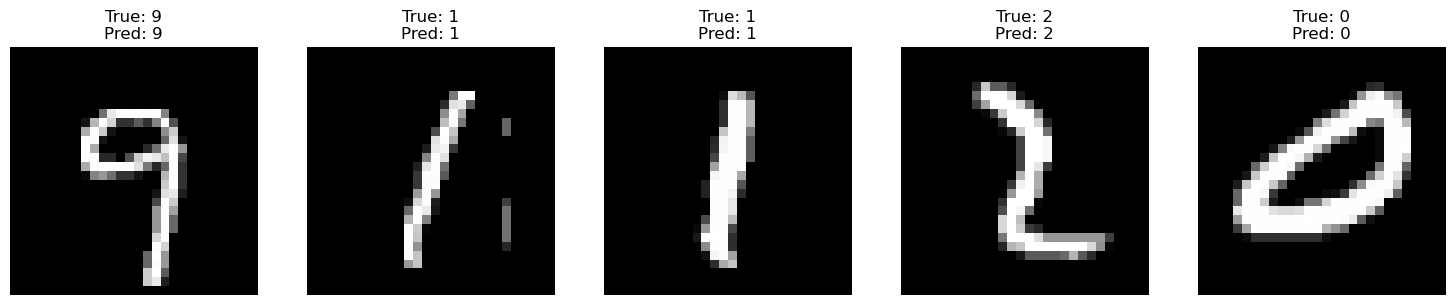

In [51]:
import matplotlib.pyplot as plt

def test_and_visualize(model, test_dataset, num_samples=5):
    # Get a batch of test data
    for x_batch, y_batch in test_dataset:
        break
    
    # Select random samples
    sample_indices = np.random.choice(len(x_batch), num_samples, replace=False)
    
    # Make predictions
    predictions = model.predict(x_batch)
    
    # Plot the results
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        # Reshape the image
        img = x_batch[idx].numpy().reshape(28, 28)
        
        # Plot the image
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Get the true and predicted labels
        true_label = np.argmax(y_batch[idx])
        pred_label = np.argmax(predictions[idx])
        
        # Set the title with true and predicted labels
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')
    
    plt.tight_layout()
    plt.show()

# After training the model, call the test_and_visualize function
test_and_visualize(model, test_dataset)